In [5]:
import xarray as xr

run = 1507

In [6]:
core_sources = xr.open_dataset(
    f"aug/32408/{run}/core_sources.h5",
    engine="h5netcdf",
    group="core_sources",
    phony_dims="access",
)

In [7]:
def add_variable_name_as_attribute(dataset: xr.Dataset) -> xr.Dataset:
    """
    Add an attribute to each variable in the dataset containing its name.
    
    Parameters:
    - dataset (xr.Dataset): The input xarray Dataset.
    
    Returns:
    - xr.Dataset: The modified Dataset with the attribute added to each variable.
    """
    for var_name in list(dataset.variables):
        dataset[var_name].attrs['IMAS_NAME'] = var_name
    return dataset

In [8]:
core_sources

<xarray.Dataset> Size: 2MB
Dimensions:                                           (phony_dim_0: 1,
                                                       phony_dim_2: 2,
                                                       phony_dim_3: 111,
                                                       phony_dim_4: 200,
                                                       phony_dim_5: 20,
                                                       phony_dim_1: 1)
Dimensions without coordinates: phony_dim_0, phony_dim_2, phony_dim_3,
                                phony_dim_4, phony_dim_5, phony_dim_1
Data variables: (12/27)
    ids_properties&creation_date                      <U8 32B ...
    ids_properties&homogeneous_time                   int32 4B ...
    ids_properties&version_put&access_layer           <U7 28B ...
    ids_properties&version_put&access_layer_language  <U6 24B ...
    ids_properties&version_put&data_dictionary        <U6 24B ...
    source[]&AOS_SHAPE                                (phony_dim_0) int32 4B ...
    ...                                                ...
    source[]&profiles_1d[]&j_parallel_SHAPE           (phony_dim_2, phony_dim_3, phony_dim_0) int32 888B ...
    source[]&profiles_1d[]&momentum_tor               (phony_dim_2, phony_dim_3, phony_dim_5) float64 36kB ...
    source[]&profiles_1d[]&momentum_tor_SHAPE         (phony_dim_2, phony_dim_3, phony_dim_0) int32 888B ...
    source[]&profiles_1d[]&total_ion_energy           (phony_dim_2, phony_dim_3, phony_dim_4) float64 355kB ...
    source[]&profiles_1d[]&total_ion_energy_SHAPE     (phony_dim_2, phony_dim_3, phony_dim_0) int32 888B ...
    time                                              (phony_dim_3) float64 888B ...

In [9]:
core_sources = (
    core_sources.swap_dims(
        {
            core_sources["source[]&identifier&name"].dims[0]: "source",
            core_sources["time"].dims[0]: "time",
            core_sources["source[]&profiles_1d[]&ion[]&label"].dims[-1]: "ion",
            core_sources["source[]&profiles_1d[]&grid&rho_tor_norm"].dims[-1]: "rho_tor_norm",
        }
    )
    .set_coords(
        [
            "source[]&identifier&name",
            "source[]&profiles_1d[]&grid&rho_tor_norm",
            "source[]&identifier&name",
            "source[]&profiles_1d[]&ion[]&label",
        ]
    )
    .assign_attrs(
        {
            "creation_date": core_sources["ids_properties&creation_date"].values,
            "data_dictionary_version": core_sources["ids_properties&version_put&data_dictionary"].values,
        }
    )
    .drop_vars(
        [
            "ids_properties&creation_date",
            "ids_properties&homogeneous_time",
            "ids_properties&version_put&access_layer",
            "ids_properties&version_put&access_layer_language",
            "ids_properties&version_put&data_dictionary",
            "source[]&identifier&index",
        ] + [variable for variable in list(core_sources.variables) if "SHAPE" in variable]
    )
)

core_sources = (
    add_variable_name_as_attribute(core_sources)
    .rename_vars(
        {
            "source[]&identifier&name": "source",
            "source[]&profiles_1d[]&grid&rho_tor_norm": "rho_tor_norm",
            "source[]&profiles_1d[]&electrons&energy": "electron_energy",
            "source[]&profiles_1d[]&electrons&particles": "electron_particles",
            "source[]&profiles_1d[]&ion[]&particles": "ion_particles",
            "source[]&profiles_1d[]&j_parallel": "j_parallel",
            "source[]&profiles_1d[]&momentum_tor": "momentum_tor",
            "source[]&profiles_1d[]&total_ion_energy": "total_ion_energy",
            "source[]&profiles_1d[]&ion[]&label": "ion",
            "source[]&profiles_1d[]&ion[]&z_ion": "ion_charge",
        }
    )
)

core_sources

<xarray.Dataset> Size: 2MB
Dimensions:             (source: 2, time: 111, rho_tor_norm: 200,
                         phony_dim_5: 20, ion: 1)
Coordinates:
    source              (source) <U3 24B ...
    rho_tor_norm        (source, time, rho_tor_norm) float64 355kB ...
    ion                 (source, time, ion) <U1 888B ...
  * time                (time) float64 888B 2.0 2.05 2.1 2.15 ... 7.4 7.45 7.5
Dimensions without coordinates: phony_dim_5
Data variables:
    electron_energy     (source, time, rho_tor_norm) float64 355kB ...
    electron_particles  (source, time, phony_dim_5) float64 36kB ...
    ion_particles       (source, time, ion, phony_dim_5) float64 36kB ...
    ion_charge          (source, time, ion) float64 2kB ...
    j_parallel          (source, time, rho_tor_norm) float64 355kB ...
    momentum_tor        (source, time, phony_dim_5) float64 36kB ...
    total_ion_energy    (source, time, rho_tor_norm) float64 355kB ...
Attributes:
    creation_date:            15/07/24
    data_dictionary_version:  3.41.0

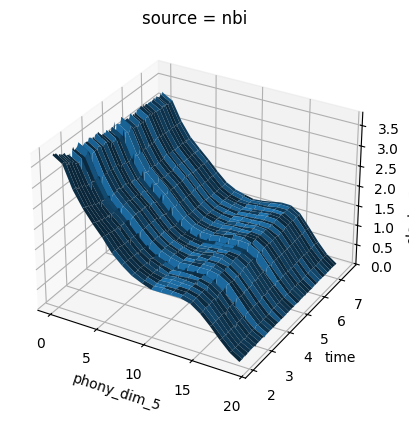

In [75]:
core_sources["electron_particles"].isel(source=0).plot.surface()